This is another in a series of blog posts highlighting built-in RDKit support for speeding up some tasks by running multiple threads at once.

Previous posts discussing this topic:

  - [Using the Multithreaded Mol Readers](https://greglandrum.github.io/rdkit-blog/posts/2023-11-11-usingmultithreadedreaders.html)

# Preliminaries

Start by reading in a bunch of molecules, multithreaded of course

In [10]:
import rdkit
print(rdkit.__version__)

2023.09.5


In [4]:
!head ../data/BLSets_actives.txt

smiles	target_chembl_id	label	pKi
Clc1ccc(cc1Cl)N2NC(=O)\C(=C\c3cccc(OCc4ccccc4)c3)\C2=O	CHEMBL1862	inactive	6.00
Cc1ccc(cc1C)N2NC(=O)\C(=C\c3oc(cc3)c4ccc(C)c(Cl)c4)\C2=O	CHEMBL1862	inactive	5.30
O=C(Nc1ccccc1)Nc2nnc(Cc3ccccc3)s2	CHEMBL1862	inactive	4.24
Brc1cc2OCOc2cc1\C=C/3\C(=O)NN(C3=O)c4ccc(I)cc4	CHEMBL1862	inactive	5.60
Nc1[nH]cnc2nnc(c3ccc(Cl)cc3)c12	CHEMBL1862	inactive	6.30
Ic1ccc(cc1)N2NC(=O)\C(=C\c3ccccc3)\C2=O	CHEMBL1862	inactive	6.22
Ic1ccc(cc1)C(=O)Nc2nnc(CCc3ccccc3)s2	CHEMBL1862	inactive	6.40
Ic1ccccc1C(=O)Nc2nnc(CCc3ccccc3)s2	CHEMBL1862	inactive	5.89
Ic1ccc(\C=C/2\C(=O)NN(C2=O)c3ccc(I)cc3)cc1	CHEMBL1862	inactive	6.10


In [5]:
from rdkit import Chem
filename = '../data/BLSets_actives.txt'
ms = [m for m in Chem.MultithreadedSmilesMolSupplier(filename,numWriterThreads=5) if m is not None]
len(ms)

91663

# Generating fingerprints

`2023.09.3` release

In [6]:
from rdkit.Chem import rdFingerprintGenerator
fpg = rdFingerprintGenerator.GetMorganGenerator()

In [7]:
%timeit fps=[fpg.GetFingerprint(m) for m in ms]

7.11 s ± 90.7 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


With the `getFingerprints()` function we can generate all the fingerprints in a single call. This uses one thread by default and isn't significantly faster:

In [8]:
%timeit fps=fpg.GetFingerprints(ms)

7.02 s ± 44.3 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


But we can also use getFingerprints with multiple threads, this does make a difference in run time:

In [9]:
%timeit fps=fpg.GetFingerprints(ms, numThreads=5)

1.56 s ± 33.5 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


There are three analogous functions for the other fingerprint forms:

- `fpg.GetCountFingerprints(ms)`
- `fpg.GetSparseFingerprints(ms)`
- `fpg.GetSparseCountFingerprints(ms)`


# Molecular standardization

`2023.09.3` and `2023.09.4` releases

First check whether or not any of the molecules in the data set have multiple fragments:

In [15]:
from collections import Counter
cntr = Counter()
for m in ms:
    frags = Chem.GetMolFrags(m)
    cntr[len(frags)] += 1
cntr

Counter({1: 86368, 2: 4662, 3: 530, 4: 56, 5: 47})

Some do... we'll standardize them by finding the fragment parent:

In [14]:
from rdkit.Chem.MolStandardize import rdMolStandardize

Since we're going to be modifying the molecules in place we need to make a copy first so that we can do multiple experiments on the same input molecules. This adds a bit of time to the overall experiments, so let's figure out how much that is:

In [16]:
%timeit cms = [Chem.Mol(m) for m in ms]

1.24 s ± 7.19 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


Find the fragment parent (largest organic fragment) for all of the molecules using a single thread:

In [18]:
%timeit cms = [Chem.Mol(m) for m in ms];rdMolStandardize.FragmentParentInPlace(cms,numThreads=1)

1min 3s ± 949 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


Using 5 threads:

In [19]:
%timeit cms = [Chem.Mol(m) for m in ms];rdMolStandardize.FragmentParentInPlace(cms,numThreads=5)

14.5 s ± 64.4 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


Other standardization functions that can operate on muliple molecules and support a `numThreads` argument:

  - `CleanupInPlace()`: cleans up the molecule by removing Hs, sanitizing, disconnecting metals, normalizing, reionizing, and assigning stereochemistry.
  - `NormalizeInPlace()`: normalizes the molecule by standardizing some functional groups
  - `ReionizeInPlace()`: rearranges charges so that the strongest acids ionize first
  - `RemoveFragmentsInPlace()`: removes common salts and solvents
  - `TautomerParentInPlace()`: finds the canonical tautomer and then calls cleanup
  - `StereoParentInPlace()`: removes all stereochemistry markers 
  - `IsotopeParentInPlace()`: removes all isotope labels
  - `ChargeParentInPlace()`: neutralizes the molecule
  - `SuperParentInPlace()`: this is the fragment, charge, isotope, stereo, and tautomer parent of the molecule
 

In [53]:
m = Chem.MolFromSmiles('CC.[Na+].[Cl-].C.[Fe].CCO')
m = rdMolStandardize.RemoveFragments(m)
Chem.MolToSmiles(m)

'C.CC.[Fe]'

In [64]:
m = Chem.MolFromSmiles('CC(O)=CCCO[Na]')
rdMolStandardize.TautomerParentInPlace(m)
Chem.MolToSmiles(m)

'CC(=O)CCC[O-].[Na+]'

# RMSD calculations
`2023.09.3` release

In [21]:
from rdkit.Chem import rdDistGeom
from rdkit.Chem import rdMolAlign
from rdkit.Chem.Draw import IPythonConsole
IPythonConsole.ipython_3d = True

Download the ligand from a recent PDB structure

[08:03:21] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

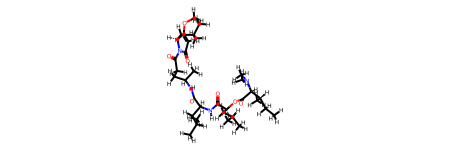

In [28]:
import requests
d = requests.get('https://www.ebi.ac.uk/pdbe/static/files/pdbechem_v2/U9X_model.sdf').text
mol = Chem.MolFromMolBlock(d,removeHs=False)
mol

You've been able to use multiple threads during conformer generation for a while, it makes a big difference:

In [30]:
mcp = Chem.Mol(mol)
ps = rdDistGeom.ETKDGv3()
ps.randomSeed = 0xc0ffee

%timeit rdDistGeom.EmbedMultipleConfs(mcp,500,ps)

2min 29s ± 236 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [31]:
mcp = Chem.Mol(mol)
ps = rdDistGeom.ETKDGv3()
ps.randomSeed = 0xc0ffee
ps.numThreads = 5
%timeit rdDistGeom.EmbedMultipleConfs(mcp,500,ps)

36 s ± 78.2 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


`GetAllConformerBestRMS()` returns the "distance matrix" between all of the molecule's conformers, it also can be nicely run in multiple threads:

In [35]:
mol_noh = Chem.RemoveHs(mol)
mcp_noh = Chem.RemoveHs(mcp)
%timeit rdMolAlign.GetAllConformerBestRMS(mcp_noh)

3.52 s ± 92.3 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [36]:
%timeit rdMolAlign.GetAllConformerBestRMS(mcp_noh, numThreads=5)

937 ms ± 26.4 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


We can use this to quickly find the conformer with the best RMSD to the crystal conformer:

In [37]:
mcp_noh.GetNumConformers()

500

Add the crystal conformer at the end of the conformer list:

In [38]:
mcp_noh.AddConformer(mol_noh.GetConformer(),assignId=True)
mcp_noh.GetNumConformers()

501

In [39]:
dmat = rdMolAlign.GetAllConformerBestRMS(mcp_noh, numThreads=5)
len(dmat)

125250

The elements of dmat are stored in the RDKit's usual way for symmetric matrices, with the indices in the order:
`[(1,0),(2,0),(2,1),(3,0),...]`, so the distances to the last conformer (the crystal conformer we just added) are at the end:

In [42]:
dists_to_xtal = dmat[-500:]
min(dists_to_xtal)

1.812529263358374

That's not a fantastic result, but the molecule I picked for this demo is super flexible and we only generated 500 conformers.